In [5]:
from fastai.vision.data import untar_data, URLs

# With an unfamiliar dataset, we have to :
# 1. Figure how is it put together
# 2. How to extract the data we need from it
# 3. What the data looks like .i.e. how is it structured with respect to labels
# https://www.robots.ox.ac.uk/~vgg/data/pets/https://www.robots.ox.ac.uk/~vgg/data/pets/
path = untar_data(URLs.PETS)

# open /Users/mton/.fastai/data/ launches an explorer for us to inspect the file
# and folder structure of the dataset
# Looks like list.txt contains the labels for the images for :
# #ID: 1:37 Class ids
# #SPECIES: 1:Cat 2:Dog
# #BREED ID: 1-25:Cat 1:12:Dog
# All images with the first letter as capital are cat images
# All images with the first letter as small are dog images
path.ls() # type: ignore

(#3) [Path('/Users/mton/.fastai/data/oxford-iiit-pet/.DS_Store'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/annotations')]

In [7]:
# We care about WHAT the pets are, not WHERE the images are
# We are doing image classification, not image localization so we will ignore
# the annotations directory for now
# And instead look at the images directory
(path/'images').ls() # type: ignore

(#7393) [Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/pug_52.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/basset_hound_112.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Siamese_193.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/shiba_inu_122.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Siamese_53.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Birman_167.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/leonberger_6.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Siamese_47.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/shiba_inu_136.jpg')...]

In [10]:
from fastai.vision.core import re

fname = (path/'images').ls()[0] # type: ignore
print(f'{fname}')
# This regular expression plucks all characters until the last underscore
# as long as the subsequent characters are digits followed by '.jpg' extension
re.findall(r'(.+)_\d+.jpg$', fname.name) # type: ignore)

/Users/mton/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg


['Egyptian_Mau']

In [13]:
from fastai.vision.data import DataBlock, CategoryBlock, ImageBlock, get_image_files, RandomSplitter, RegexLabeller
from fastai.vision.augment import aug_transforms, Resize
from fastai.vision.core import using_attr

pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock), # type: ignore
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    # Presizing the images to 460x460 pixels before augmentation because:
    # - Upscaling to larger dimensions so that transform and crop ops don't
    #   include empty corners to confuse model, and yield better pixel 
    #   interpolation i.e. large images have margins to crop and lose less data
    # - Compose all augmentation in one GPU pass as opposed to performing 
    #   individual ops with interpolation at each step 
    #   (reduces image degradation)
    item_tfms=Resize(460), # type: ignore
    # NOTE: On TRAINING set uniform window cropping (224 * 244) is performed 
    # RANDOMLY, as opposed to VALIDATION set where it's CENTER cropped
    # Augmentation is performed on TRAINING set only, not VALIDATION set
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
    )

dls=pets.dataloaders(path/'images')

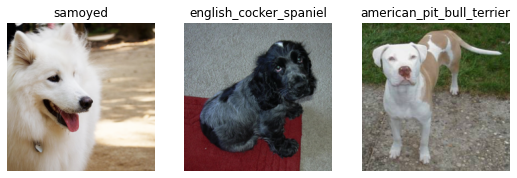

In [20]:
dls.show_batch(nrows=1, ncols=3)

In [21]:
pets1 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # type: ignore
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
)

pets.summary(path/'images') # type: ignore

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/mton/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/mton/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(30))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


In [22]:
from fastai.vision.learner import vision_learner, error_rate
from fastai.vision.models import resnet34

learn = vision_learner(dls, arch=resnet34, metrics=error_rate)
# Loss is whatever function we are using to train the parameters of our model
# We haven't chosen a loss function here, so what is fastai using for loss
# fastai uses a default function based on the DATA and MODEL we are using
# In this case we have IMAGE data and CATEGORICAL outcomes, so fastai will use
# Cross Entropy Loss by default
learn.fine_tune(2)

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.521961,0.331926,0.113667,10:37


epoch,train_loss,valid_loss,error_rate,time
0,0.532902,0.331273,0.102165,13:53
1,0.308981,0.240302,0.075778,14:01


In [31]:
# Cross Entropy Loss benefits include :
# 1) Works when our dependent variable has more than 2 categories
# 2) Results in faster and more reliable training

# view activation and labels
x,y = dls.one_batch()
# Our batch size is 64 so we have 64 rows
# Each row has an integer between 0 and 36 (37 possible pet breeds)
print(f'{y} # our dependent variable')

# view predictions (activations of the final layer of our neural network)
# get_preds() takes in an iterator of batches or dataset index (0 = train, 1=valid)
# and returns a tuple of predictions and targets
# - we are feeding in a single batch of data
# - we already have targets, so we ignore the 2nd return value by assigning it 
#   to the special variable._
preds,_ = learn.get_preds(dl=[(x,y)]) # type: ignore
print(f'{preds[0]} # predictions')

# The actual predictions are 37 probabilities that sum to 1.0f
print(f'{len(preds[0])} => {preds[0].sum()} # verify that preditions sum to 1.0f')

TensorCategory([26, 10,  2, 27,  1, 35, 14, 25, 20, 18, 21,  6, 15, 25, 15,  0,
                24, 14, 21,  9,  6, 21,  8, 24, 18, 18, 16,  7, 26, 23, 24,  7,
                34, 31, 20, 30, 13, 27, 20, 13, 16,  5,  8,  5,  7, 25, 31, 18,
                 7, 24,  9, 17,  9, 33, 21,  3, 12, 13, 25, 23, 16, 20, 11, 15]) # our dependent variable


TensorBase([5.3764e-04, 1.5582e-06, 7.2861e-08, 8.5206e-07, 5.8095e-08,
            8.4306e-09, 2.8630e-10, 9.7283e-08, 8.1779e-08, 1.5454e-05,
            1.3612e-05, 6.7999e-03, 2.7978e-07, 1.0680e-07, 7.9284e-07,
            8.1714e-07, 3.7427e-08, 3.5436e-03, 8.0547e-07, 1.2633e-06,
            1.1654e-06, 1.5330e-09, 3.6291e-08, 2.0504e-08, 8.9767e-08,
            1.8645e-09, 9.8907e-01, 6.1430e-08, 5.9046e-09, 1.2534e-09,
            2.9289e-09, 5.2611e-08, 8.6527e-06, 1.4516e-06, 1.3517e-06,
            2.6442e-08, 1.4834e-06]) # predictions
37 => 1.0000001192092896 # verify that preditions sum to 1.0f


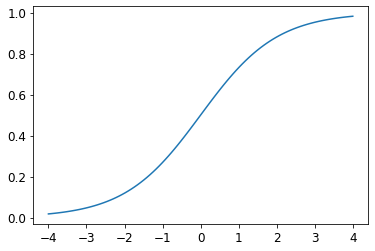

In [36]:
from fastai.vision.core import torch
from fastbook import plot_function

# Softmax

plot_function(torch.sigmoid, min=-4, max=4)

In [39]:
# random numbers with a standard deviation of 2
# TODO : why? Understand standard deviation kk
# For this example we assume 6 images and 2 categories : 3s and 7s
acts = torch.randn((6,2))*2 # multiply by 2 = standard deviation of 2 
acts

tensor([[ 0.5630,  0.1123],
        [ 1.0454, -0.4767],
        [-0.0998,  1.0527],
        [-0.0170,  1.4581],
        [ 0.2663,  1.7280],
        [-2.0313, -1.7775]])

In [40]:
# normalizes values to be between 0 and 1
acts.sigmoid()

tensor([[0.6372, 0.5281],
        [0.7399, 0.3830],
        [0.4751, 0.7413],
        [0.4958, 0.8112],
        [0.5662, 0.8492],
        [0.1160, 0.1446]])

In [43]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6108, 0.8209, 0.2400, 0.1862, 0.1882, 0.4369])

In [ ]:
# softmax is the multi-category equivalent of sigmoid
# use it whenever we have more than 2 categories and the probability of each
# category should sum to 1.0f
# NOTE : often used even when there's only 2 categories for consistency lol
# Intuitively the softmax function REALLY wants to pick one class among the 
# others, given exponential AMPLIFIES any slight relative differences
def softmax(x):
    # exp = exponential function
    # defined as e**x, where is is approximately 2.718
    # this is the inverse of the natural logarithm function 
    # exp is always positive and increases VERY rapidly
    return exp(x)/exp(x).sum(dim=1, keepdim=True) # type: ignore

In [44]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6108, 0.3892],
        [0.8209, 0.1791],
        [0.2400, 0.7600],
        [0.1862, 0.8138],
        [0.1882, 0.8118],
        [0.4369, 0.5631]])

In [46]:
from fastai.vision.data import tensor

# Cross Entropy Loss :
# - softmax is the first part
# - log likelihood is the second part

# Log Likelihood
targ = tensor([0,1,0,1,1,0])
idx = range(6)

# We are picking the loss from the column containing the correct label
# And implicitly since all the columns sum to 1.0f because of softmax,
# when we push the activation for the correct label as HIGH as possible
# we are also decreasing the activations for the remaining columns
# This works for binary/2-catagories (3,7) but scales to N categories (0-9)
# TODO : The book formats the numbers as a table nicely ... figure out how to do
# that in Jupyter here
sm_acts[idx, targ]

tensor([0.6108, 0.1791, 0.2400, 0.8138, 0.8118, 0.4369])

In [50]:
from fastai.vision.data import F

# nll_loss (negative log likelihood loss) is a built-in pytorch function equivalent
builtin_tensor = F.nll_loss(sm_acts, targ, reduction='none')

# nll_loss applies the log afterwards, so the output values will be negative
manual_tensor = -sm_acts[idx, targ]
print(f'{manual_tensor} # manual tensor \n{builtin_tensor} # builtin tensor')

tensor([-0.6108, -0.1791, -0.2400, -0.8138, -0.8118, -0.4369]) # manual tensor 
tensor([-0.6108, -0.1791, -0.2400, -0.8138, -0.8118, -0.4369]) # builtin tensor
